In [1]:
!pip install torchsummary
!pip install tensorboard

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import pandas as pd
import os
import numpy as np
import pytorch_lightning as pl
import random
from torchmetrics import Accuracy
from torchsummary import summary

In [3]:
def load_random_mel_spectrograms(spectrogram_dir, num_samples=3):
    all_files = [f for f in os.listdir(spectrogram_dir) if f.endswith('.pt')]
    
    random_files = random.sample(all_files, num_samples)
    
    mel_spectrograms = [torch.load(os.path.join(spectrogram_dir, f)) for f in random_files]
    
    return mel_spectrograms, random_files

In [4]:
spectrogram_dir = '/kaggle/input/mel-train/train'

In [5]:
mel_spectrograms, random_files = load_random_mel_spectrograms(spectrogram_dir, num_samples=3)

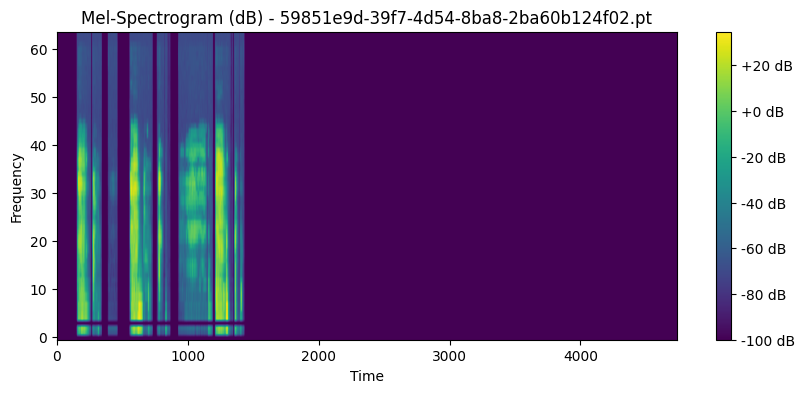

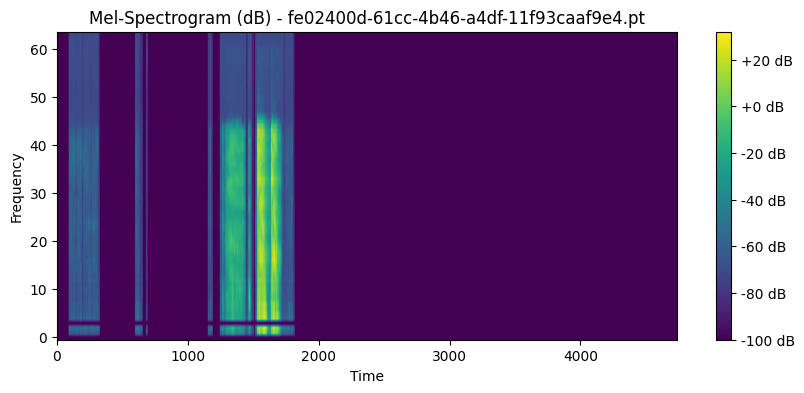

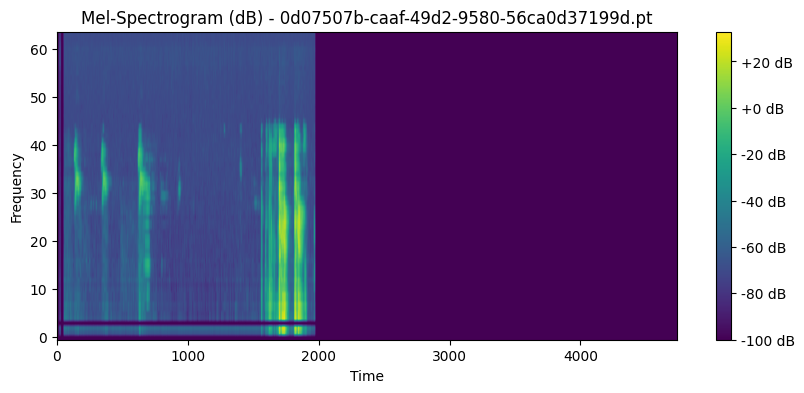

In [6]:
def plot_mel_spectrograms(mel_spectrograms, filenames):
    for i, (mel_spectrogram, filename) in enumerate(zip(mel_spectrograms, filenames)):
        plt.figure(figsize=(10, 4))
        plt.imshow(mel_spectrogram.squeeze().numpy(), cmap='viridis', origin='lower', aspect='auto')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel-Spectrogram (dB) - {filename}')
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        plt.show()

plot_mel_spectrograms(mel_spectrograms, random_files)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [9]:
set_seed(42)

In [10]:
transform = transforms.Normalize(mean=[-14.0], std=[17.0])

In [11]:
spectrogram_dir_train = '/kaggle/input/mel-train/train'
augmented_dir_train = '/kaggle/input/mel-augmented-2/mel_spectrograms/augmented_train'
spectrogram_dir_test = '/kaggle/input/mel-test/test'

In [12]:
class MelSpectrogramDataset(Dataset):
    def __init__(self, csv_file, spectrogram_dirs, augmented_dir=None, test=None, transform=None):
        self.data = pd.read_csv(csv_file)
        self.spectrogram_dirs = spectrogram_dirs
        self.augmented_dir = augmented_dir
        self.test = test
        self.transform = transform
        self.file_list = self._create_file_list()

    def _create_file_list(self):
        file_list = []
        if not self.test:
            # Añadir archivos originales y aumentados
            for spectrogram_dir in self.spectrogram_dirs:
                for uuid in self.data['uuid']:
                    file_path = os.path.join(spectrogram_dir, f"{uuid}.pt")
                    if os.path.exists(file_path):
                        label = self.data.loc[self.data['uuid'] == uuid, 'covid'].values[0]
                        file_list.append((file_path, label))

            # Añadir archivos aumentados con clase 1 (COVID positivo)
            if self.augmented_dir:
                for file_name in os.listdir(self.augmented_dir):
                    if file_name.endswith(".pt"):
                        file_path = os.path.join(self.augmented_dir, file_name)
                        file_list.append((file_path, 1))  # Asignar clase 1 a todos los datos aumentados

            return file_list
        else:
            for spectrogram_dir in self.spectrogram_dirs:
                for uuid in self.data['uuid']:
                    file_path = os.path.join(spectrogram_dir, f"{uuid}.pt")
                    if os.path.exists(file_path):
                        label = -1
                        file_list.append((file_path, label))
            return file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path, label = self.file_list[idx]
        mel_spectrogram = torch.load(file_path)
        if self.transform:
            mel_spectrogram = self.transform(mel_spectrogram)
        return mel_spectrogram, label

In [13]:
train_dataset = MelSpectrogramDataset(
    csv_file='/kaggle/input/udp-dl-trabajo-3-covid-19/train.csv',
    spectrogram_dirs=[spectrogram_dir_train],
    augmented_dir=augmented_dir_train,
    test = False,
    transform=transform
)

In [14]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [15]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=3)

In [16]:
test_dataset = MelSpectrogramDataset(
    csv_file='/kaggle/input/udp-dl-trabajo-3-covid-19/test.csv',
    spectrogram_dirs=[spectrogram_dir_test],
    test = True,
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=3)

In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [18]:
class CoughCNN(pl.LightningModule):
    def __init__(self):
        super(CoughCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        
        #calcular el tamaño de la entrada para la capa fully connected
        self._initialize_fc()

        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.5)

        self.accuracy = Accuracy(task="binary")

    def _initialize_fc(self):
        #tensor de prueba a través de las capas convolucionales y de agrupación
        with torch.no_grad():
            sample_tensor = torch.zeros(1, 1, 64, 4738)  #dimensiones del mel-spectrogram
            sample_tensor = self.pool(F.relu(self.conv1(sample_tensor)))
            sample_tensor = self.pool(F.relu(self.conv2(sample_tensor)))
            self.fc_input_size = sample_tensor.numel()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.fc_input_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        self.log('val_loss', loss, on_epoch=True)

        preds = torch.argmax(outputs, dim=1)
        acc = self.accuracy(preds, labels)
        self.log('val_accuracy', acc, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'interval': 'epoch',
                'frequency': 1
            }
        }

In [19]:
class MetricsLogger(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get('train_loss')
        if train_loss is not None:
            self.train_losses.append(train_loss.cpu().item())

    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_loss is not None:
            self.val_losses.append(val_loss.cpu().item())
        
        val_accuracy = trainer.callback_metrics.get('val_accuracy')
        if val_accuracy is not None:
            self.val_accuracies.append(val_accuracy.cpu().item())

    def plot_metrics(self):
        if self.train_losses and self.val_losses:
            plt.figure(figsize=(10, 5))
            plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label='Pérdida Entrenamiento')
            plt.plot(range(1, len(self.val_losses) + 1), self.val_losses, label='Pérdida Validación')
            plt.xlabel('Épocas')
            plt.ylabel('Pérdida')
            plt.title('Pérdida de Entrenamiento y Validación por Época')
            plt.legend()
            plt.show()

        if self.val_accuracies:
            plt.figure(figsize=(10, 5))
            plt.plot(range(1, len(self.val_accuracies) + 1), self.val_accuracies, label='Accuracy Validación')
            plt.xlabel('Épocas')
            plt.ylabel('Pérdida')
            plt.title('Accuracy de Validación por Época')
            plt.legend()
            plt.show()


In [20]:
model = CoughCNN()

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#modelo
summary(model, input_size=(1, 64, 4738))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 64, 4738]             160
         MaxPool2d-2         [-1, 16, 32, 2369]               0
            Conv2d-3         [-1, 32, 32, 2369]           4,640
         MaxPool2d-4         [-1, 32, 16, 1184]               0
            Linear-5                  [-1, 128]      77,594,752
           Dropout-6                  [-1, 128]               0
            Linear-7                    [-1, 2]             258
Total params: 77,599,810
Trainable params: 77,599,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.16
Forward/backward pass size (MB): 69.40
Params size (MB): 296.02
Estimated Total Size (MB): 366.58
----------------------------------------------------------------


In [22]:
metrics_logger = MetricsLogger()

In [23]:
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True)
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min', verbose=True)

In [24]:
trainer = pl.Trainer(
    max_epochs=15,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else None,
    callbacks=[early_stopping, checkpoint_callback, metrics_logger]
)

In [25]:
trainer.fit(model, train_loader, val_loader)

2024-06-23 20:03:25.248172: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 20:03:25.248267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 20:03:25.352939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00014: reducing learning rate of group 0 to 1.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

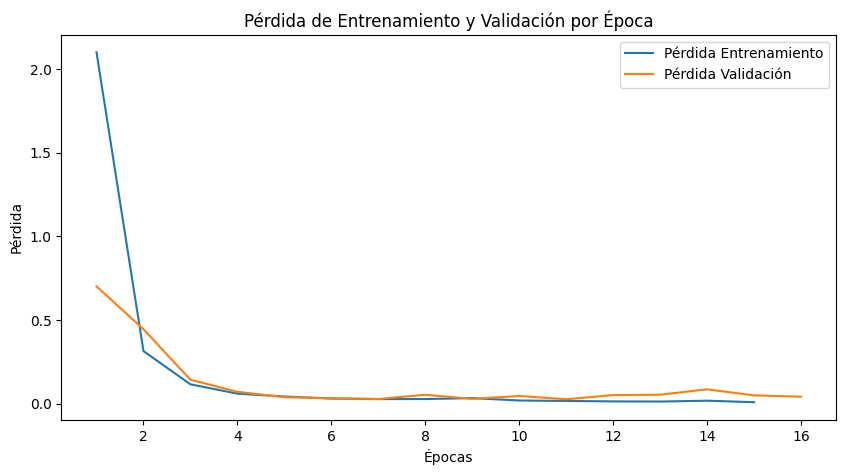

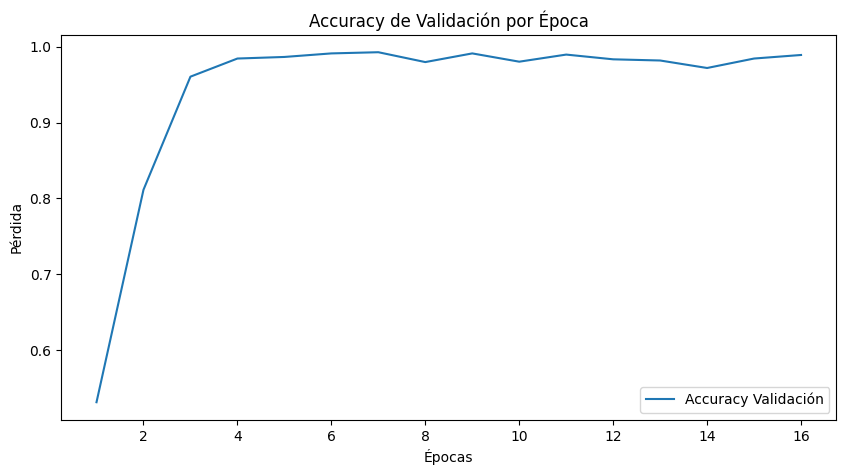

In [26]:
metrics_logger.plot_metrics()

In [27]:
model = CoughCNN.load_from_checkpoint(checkpoint_callback.best_model_path)

In [28]:
predictions = []
model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        #print('ola')
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted)
        predictions.extend(predicted.cpu().numpy())
#print(predictions)

In [29]:
test_data = pd.read_csv('/kaggle/input/udp-dl-trabajo-3-covid-19/test.csv')
uuids = test_data['uuid'].tolist()
#print(uuids)

In [30]:
uuid_to_prediction = {uuid: None for uuid in uuids}
#print(uuid_to_prediction)

In [31]:
#print(test_dataset.file_list)
for idx, (file_path, _) in enumerate(test_dataset.file_list):
    #print(idx)
    uuid = os.path.basename(file_path).replace('.pt', '')
    #print(uuid)
    uuid_to_prediction[uuid] = predictions[idx]
    #print(predictions[idx])
#print(uuid_to_prediction)

In [32]:
#le doy etiqueta random a los audios que no existen
#print(uuid_to_prediction)
for uuid, prediction in uuid_to_prediction.items():
    if prediction is None:
        uuid_to_prediction[uuid] = np.random.randint(0, 2)
#print(uuid_to_prediction)

In [33]:
final_predictions = [uuid_to_prediction[uuid] for uuid in uuids]

In [34]:
submission = pd.DataFrame({
    'ID': range(0, len(uuids)),
    'label': final_predictions
})

In [35]:
submission.to_csv('/kaggle/working/submission.csv', index=False)

In [36]:
print("Predictions saved to /kaggle/working/test_predictions.csv")

Predictions saved to /kaggle/working/test_predictions.csv
